In [ ]:
from pathlib import Path
import xarray as xr
import cfgrib
import dask

In [ ]:
from dask.distributed import Client
client = Client()

2023-03-22 18:50:38,939 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/39/6h0p929579n8vrp25cjkbz3h0000gn/T/dask-worker-space/worker-kauktk13', purging
2023-03-22 18:50:38,940 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/39/6h0p929579n8vrp25cjkbz3h0000gn/T/dask-worker-space/worker-udhajcnh', purging
2023-03-22 18:50:38,940 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/39/6h0p929579n8vrp25cjkbz3h0000gn/T/dask-worker-space/worker-308153tk', purging


In [ ]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 3
Total threads: 6,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:49355,Workers: 3
Dashboard: http://127.0.0.1:8787/status,Total threads: 6
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:49366,Total threads: 2
Dashboard: http://127.0.0.1:49368/status,Memory: 10.67 GiB
Nanny: tcp://127.0.0.1:49358,


In [ ]:
maskdir = Path("/Volumes/FIBOREAL/fiweps_data/GIS/raster_masks/")
mask = maskdir / "glaciermask_thresh_1m_dilate2.nc"
with xr.open_dataset(mask) as src:
    glaciermask = src.glaciermask

Both ERA5 and JRA55 go by month, at least recently 

In [ ]:
era5dir = Path("/Volumes/CWMobileSSD/Climate/ERA5/sd_grib")
jra55dir = Path("/Volumes/CWMobileSSD/Climate/JRA55/snow")
era5test = "e5.oper.an.sfc.128_141_sd.ll025sc.2021030100_2021033123.grb"
jra55prefix = "anl_land.065_snwe.reg_tl319."

In [ ]:
monthstr_jra55 = era5test[-25:-6] + "18"
monthstr_jra55

'2021030100_2021033118'

In [ ]:
(era5dir / era5test).name

'e5.oper.an.sfc.128_141_sd.ll025sc.2021030100_2021033123.grb'

In [ ]:
jra55path = jra55dir / f"{jra55prefix}{monthstr_jra55}"
jra55path.exists()

True

In [ ]:
with xr.open_dataset(jra55path, engine="cfgrib") as src:
    snow_jra = src.sd

# ds_era = xr.open_dataset(era5dir / era5test, engine="cfgrib", 
#                          chunks={"latitude": 50, "longitude": 50})

# ds_era = xr.open_dataset(era5dir / era5test, engine="cfgrib", 
#                         chunks={"time": 744, "latitude": 1, "longitude": 1})

ds_era = xr.open_dataset(era5dir / era5test, engine="cfgrib")

In [ ]:
snow_jra.chunksizes

Frozen({})

In [ ]:
ds_era.chunksizes

Frozen({})

In [ ]:
import gc 
gc.collect()

80

In [ ]:
snow_jra_era = snow_jra.interp_like(
    ds_era, method='nearest') / 1000
snow_jra_era

<xarray.DataArray 'sd' (time: 744, latitude: 721, longitude: 1440)>
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [0.02001953, 0.02001953, 0.01989746, ..., 0.02020264,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
...
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]]], dtype=float32)
Coordinates:
    step       timedelta64[ns] 00:00:00
    surface    float64 0.0
  * time       (time) datetime64[ns] 2021-03-01 ... 2021-03-31T23:00:00
  * latitude   (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8

In [ ]:
combined_DS = ds_era.sd.where(
    glaciermask==0).combine_first(
    snow_jra.fillna(0).interp_like(
    ds_era, method='nearest') / 1000)
combined_DS

<xarray.DataArray 'sd' (time: 744, latitude: 721, longitude: 1440)>
array([[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [10., 10., 10., ..., 10., 10., 10.],
        [10., 10., 10., ..., 10., 10., 10.],
        [10., 10., 10., ..., 10., 10., 10.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [10., 10., 10., ..., 10., 10., 10.],
        [10., 10., 10., ..., 10., 10., 10.],
        [10., 10., 10., ..., 10., 10., 10.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
...
        ...,
        [10., 10., 10., ..., 10., 10., 10.],
        [10., 10., 10., ..., 10., 10., 10.],
        [10., 10., 10., ..., 10., 10., 10.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [10., 10., 10., ..., 10., 10., 10.],
        [10., 10., 10., ..., 10., 10., 10.],
        [10., 10., 10., ..., 10., 10., 10.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [10., 10., 10., ..., 10., 10., 10.],
        [10., 10., 10., ..., 10., 10., 10.],
        [10., 10., 10., ..., 10., 10., 10.]]], dtype=float32)
Coordinates:
    number      int64 ...
  * time        (time) datetime64[ns] 2021-03-01 ... 2021-03-31T23:00:00
    step        timedelta64[ns] 00:00:00
    surface     float64 0.0
  * latitude    (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    valid_time  (time) datetime64[ns] ...
    crs         object ...
Attributes: (12/30)
    GRIB_paramId:                             141
    GRIB_dataType:                            an
    GRIB_numberOfPoints:                      1038240
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_shortName:                           sd
    GRIB_totalNumber:                         0
    GRIB_units:                               m of water equivalent
    long_name:                                Snow depth
    units:                                    m of water equivalent
    standard_name:                            lwe_thickness_of_surface_snow_a...

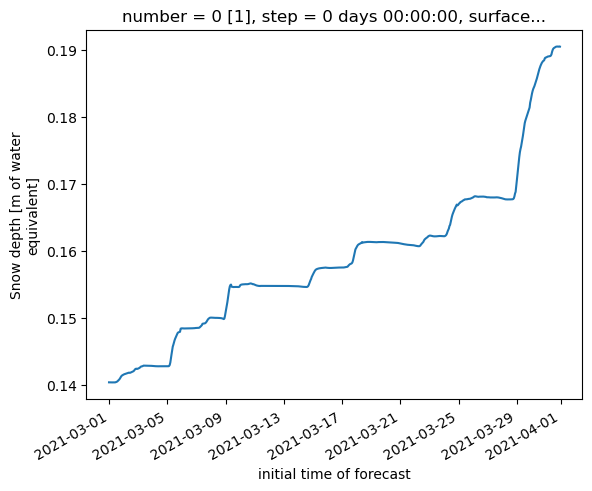

In [ ]:
combined_DS.sel(latitude=64, longitude=203).plot()

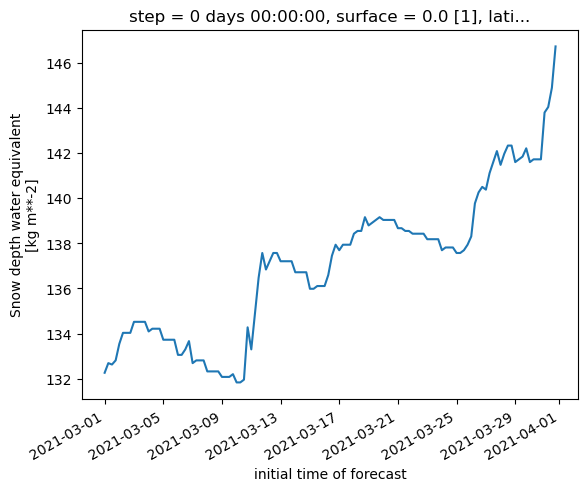

In [ ]:
snow_jra.sel(latitude=64, longitude=213, method='nearest').plot()

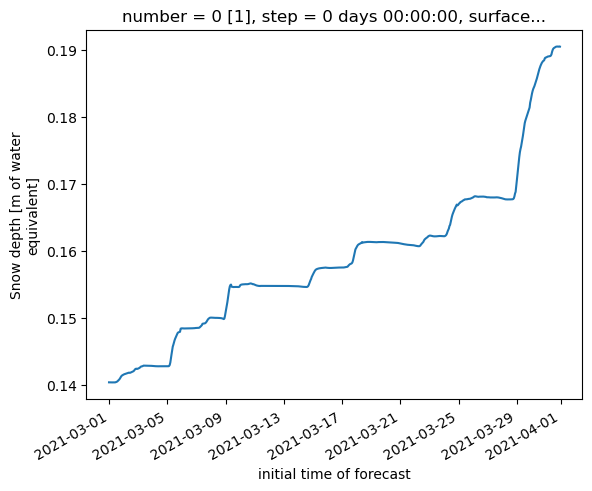

In [ ]:
ds_era.sd.sel(latitude=64, longitude=203).plot()

### Plotting for test

In [ ]:
import cartopy.crs as ccrs
import cartopy.feature as cf
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np

In [ ]:
bins = np.arange(0, 0.7, 0.1)
cmap = plt.get_cmap('Blues', len(bins))
norm = mpl.colors.BoundaryNorm(boundaries=bins, ncolors=len(bins)-1 )

JRA55 interpolated to ERA5

In [ ]:
snow_jra_era = snow_jra.interp_like(
    ds_era, method='nearest') / 1000
snow_jra_era

<xarray.DataArray 'sd' (time: 744, latitude: 721, longitude: 1440)>
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [0.02001953, 0.02001953, 0.01989746, ..., 0.02020264,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
...
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]]], dtype=float32)
Coordinates:
    step       timedelta64[ns] 00:00:00
    surface    float64 0.0
  * time       (time) datetime64[ns] 2021-03-01 ... 2021-03-31T23:00:00
  * latitude   (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8

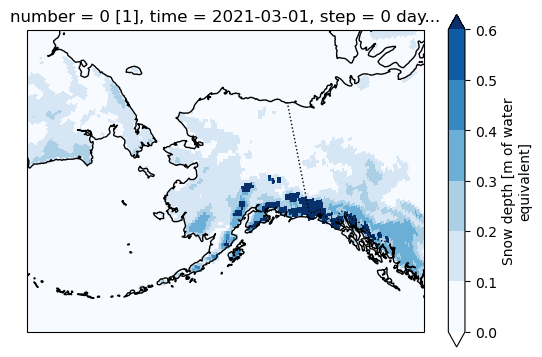

In [ ]:
projection = ccrs.AlbersEqualArea(
    central_longitude=-154.0, central_latitude=50.0, 
    standard_parallels=(55.0, 65.0))
ax = plt.axes(projection=projection)
ax.set_extent([-180, -130, 48, 75])
ax.coastlines()
ax.add_feature(cf.BORDERS, linestyle=':')
ds_era.sd.isel(time=0).plot(
    cmap=cmap, norm=norm, 
    cbar_kwargs={'ticks': bins, 'extend': 'both', "shrink": 0.9},
    transform=ccrs.PlateCarree(),
    ax=ax,
)

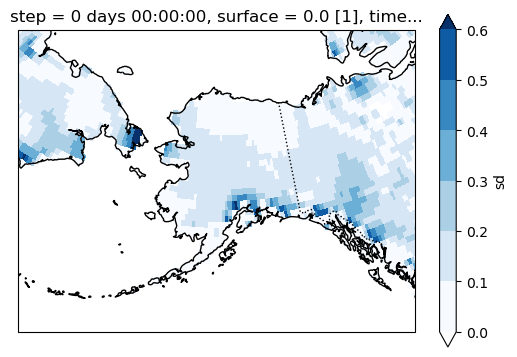

In [ ]:
projection = ccrs.AlbersEqualArea(
    central_longitude=-154.0, central_latitude=50.0, 
    standard_parallels=(55.0, 65.0))
ax = plt.axes(projection=projection)
ax.set_extent([-180, -130, 48, 75])
ax.coastlines()
ax.add_feature(cf.BORDERS, linestyle=':')
snow_jra_era.isel(time=0).plot(
    cmap=cmap, norm=norm, 
    cbar_kwargs={'ticks': bins, 'extend': 'both', "shrink": 0.9},
    transform=ccrs.PlateCarree(),
    ax=ax,
)

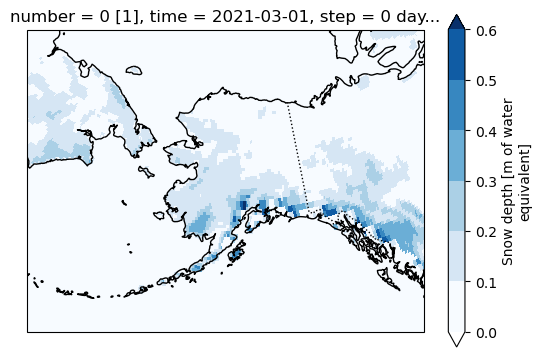

In [ ]:
projection = ccrs.AlbersEqualArea(
    central_longitude=-154.0, central_latitude=50.0, 
    standard_parallels=(55.0, 65.0))
ax = plt.axes(projection=projection)
ax.set_extent([-180, -130, 48, 75])
ax.coastlines()
ax.add_feature(cf.BORDERS, linestyle=':')
combined_DS.isel(time=0).plot(
    cmap=cmap, norm=norm, 
    cbar_kwargs={'ticks': bins, 'extend': 'both', "shrink": 0.9},
    transform=ccrs.PlateCarree(),
    ax=ax,
)

### Save grib file

In [ ]:
ds_era['sd'] = combined_DS
ds_era

<xarray.Dataset>
Dimensions:     (time: 744, latitude: 721, longitude: 1440)
Coordinates:
    number      int64 ...
  * time        (time) datetime64[ns] 2021-03-01 ... 2021-03-31T23:00:00
    step        timedelta64[ns] ...
    surface     float64 ...
  * latitude    (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    valid_time  (time) datetime64[ns] ...
    crs         object ...
Data variables:
    sd          (time, latitude, longitude) float32 0.0 0.0 0.0 ... 10.0 10.0
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2023-03-20T14:33 GRIB to CDM+CF via cfgrib-0.9.1...

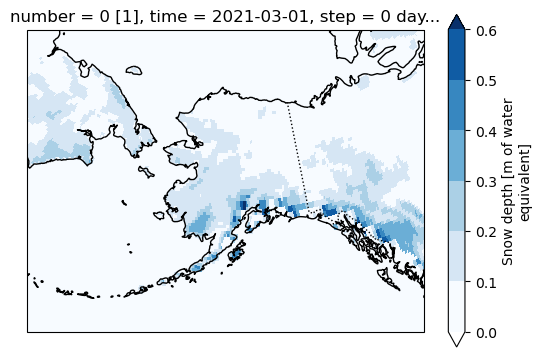

In [ ]:
projection = ccrs.AlbersEqualArea(
    central_longitude=-154.0, central_latitude=50.0, 
    standard_parallels=(55.0, 65.0))
ax = plt.axes(projection=projection)
ax.set_extent([-180, -130, 48, 75])
ax.coastlines()
ax.add_feature(cf.BORDERS, linestyle=':')
ds_era.sd.isel(time=0).plot(
    cmap=cmap, norm=norm, 
    cbar_kwargs={'ticks': bins, 'extend': 'both', "shrink": 0.9},
    transform=ccrs.PlateCarree(),
    ax=ax,
)

In [ ]:
outpth = Path("/Volumes/CWMobileSSD/Climate/ERA5/sd_synthetic_grib")

In [ ]:
cfgrib.__version__

'0.9.10.3'

In [ ]:
from cfgrib.xarray_to_grib import to_grib

In [ ]:
to_grib(ds_era, outpth / ("synth_" + era5test))

/Users/christine/miniconda3/envs/dyndown/lib/python3.11/site-packages/cfgrib/xarray_to_grib.py:261: FutureWarning: GRIB write support is experimental, DO NOT RELY ON IT!
  warnings.warn("GRIB write support is experimental, DO NOT RELY ON IT!", FutureWarning)
